## Reading Handwritten Digits Model

In [2]:
import torch
import torchvision 
from torchvision.datasets import MNIST

dataset = MNIST(root = 'data/', download = True)

0it [00:00, ?it/s]Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to data/MNIST\raw\train-images-idx3-ubyte.gz
9920512it [00:03, 2700367.44it/s]                             
Extracting data/MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST\raw
32768it [00:00, 199672.47it/s]           
0it [00:00, ?it/s]Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to data/MNIST\raw\train-labels-idx1-ubyte.gz
Extracting data/MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST\raw
1654784it [00:00, 2311725.60it/s]                             
8192it [00:00, 71244.53it/s]            
Extracting data/MNIST\raw\t10k-images-idx3-ubyte.gz to data/MNIST\raw
Extracting data/MNIST\raw\t10k-labels-idx1-ubyte.gz to data/MNIST\raw
Processing...
Done!


In [6]:
len(dataset)

(<PIL.Image.Image image mode=L size=28x28 at 0x26E2B0B05E0>, 5)

In [5]:
test_dataset = MNIST(root = 'data/', train = False)

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

Label: 3


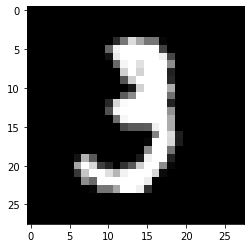

In [8]:
image, label = dataset[10]
plt.imshow(image, cmap = 'gray')
print("Label:", label)

In [10]:
import torchvision.transforms as transforms

In [13]:
#Convert image to tensor
dataset = MNIST(root = 'data/', train = True, transform = transforms.ToTensor())
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


Each image is a 1x28x28 tensor where the first dimension is used to keep track of colour channels. These images are grayscale so there is only 1 colour channel but in other cases, there would be 3 (RGB).

In [18]:
# Method to split training set into a training and validation set

import numpy as np

def split_indices(n, percent):
    
    n_val = int(percent*n)
    indices = np.random.permutation(n)

    return indices[n_val:], indices[:n_val] 

In [19]:
training_set, validation_set = split_indices(len(dataset), percent = 0.2)

In [21]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [22]:
batch_size = 100

#Training sampler and dataloader
training_sampler = SubsetRandomSampler(training_set)
training_loader = DataLoader(dataset, batch_size, sampler = training_sampler)

#Validation sampler and dataloader
validation_sampler = SubsetRandomSampler(validation_set)
validation_loader = DataLoader(dataset,batch_size, sampler = validation_sampler)


### Model Generation 

In [23]:
import torch.nn as nn

input_size = 28*28
num_classes = 10

#Logistic Regression Model
model = nn.Linear(input_size, num_classes)

In [24]:
class mnist_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out

model = mnist_model()

In [27]:
# Test to see if the model works correctly
for images, labels in training_loader:
    outputs = model(images)
    break

print('Outputs.shape:', outputs.shape)
print('Sample outputs:\n', outputs[:2].data)

Outputs.shape: torch.Size([100, 10])
Sample outputs:
 tensor([[-0.3113,  0.2567, -0.0281,  0.0974, -0.3286, -0.0347,  0.0455, -0.0727,
         -0.0526, -0.2345],
        [-0.1758,  0.0624,  0.0589, -0.0055, -0.2594, -0.1117,  0.1572, -0.0145,
         -0.1551, -0.2076]])


Use softmax function to convert each of the 10 outputs into a probability (which should be a number between 0 and 1).

In [29]:
# Softmax function is included in this package
import torch.nn.functional as F

In [30]:
probs = F.softmax(outputs, dim = 1)

In [31]:
# Return highest probability and index of the highest probability

max_probs, prediction = torch.max(probs, dim = 1)

### Evaluation Metric and Loss Function

Cross entropy loss function is used for this classification problem. Cross entropy in the ```torch.nn.functional``` package will perform softmax internally.

In [32]:
loss_function = F.cross_entropy

In [35]:
loss = loss_function(outputs, labels)

### Optimizer

In [36]:
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [38]:
def batch_loss(model, loss_function, xb, yb, opt = None, metric = None):

    predictions = model(xb)
    loss = loss_function(predictions, yb)

    if opt is not None:
        # Compute gradients
        loss.backward()
        # Update parameters
        opt.step()
        # Reset gradients to 0
        opt.zero_grad()

    accuracy = None
    if metric is not None:
        # Compute the metric
        accuracy = metric(predictions, yb)
    
    return loss.item(), len(xb), accuracy

In [39]:
# This function will calculate the overall loss for the validation set.

def evaluate(model, loss_function, valid_dl, metric = None):
    with torch.no_grad():

        # Pass each batch through the model
        results = [batch_loss(model, loss_function, xb, yb, metric = metric) for xb, yb in valid_dl]

        # Separate losses, counts, and metrics
        losses, nums, metrics = zip(*results)

        # Total size of the dataset
        total = np.sum(nums)

        # Average loss across batches
        average_loss = np.sum(np.multiply(losses, nums)) / total
        average_metric = None
        if metric is not None:
            # Average of metric across batches
            average_metric = np.sum(np.multiply(metrics, nums)) / total
    
    return average_loss, total, average_metric

In [41]:
def accuracy(outputs, labels):
    _, predictions = torch.max(outputs, dim = 1)
    return torch.sum(predictions == labels).item() / len(predictions)

In [ ]:
accuracy(outputs, labels)

### Training

In [1]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

NameError: name 'torch' is not defined

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [ ]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()